In [5]:
import re
import pandas as pd
from collections import defaultdict
import operator
from pprint import pprint

# Set Pandas to display all rows of dataframes
pd.set_option('display.max_rows', 500)

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [6]:
sections = pd.read_csv('sections.csv')

In [7]:
words = pd.read_csv('words.csv')
words.head()

,Unnamed: 0,word_num,word,sentence_num,section_num,book_title,book_num,lemma,POS,stop
0,0,1,I,1,1,ADI PARVA,1,-PRON-,PRON,True
1,1,1,Om,2,1,ADI PARVA,1,Om,PROPN,False
2,2,2,!,2,1,ADI PARVA,1,!,PUNCT,False
3,3,1,Having,3,1,ADI PARVA,1,have,VERB,False
4,4,2,bowed,3,1,ADI PARVA,1,bow,VERB,False


In [8]:
bookTitles = []
for i in range(len(sections)):
    bookTitles.append(sections.loc[i]['book_title'])
bookTitles = (set(bookTitles))
bookTitles = list(bookTitles)
bookTitles

['SHALYA-PARVA',
 'KARNA-PARVA',
 'MAHAPRASTHANIKA PARVA',
 'ADI PARVA',
 'VIRATA PARVA',
 'DRONA PARVA',
 'UDYOGA PARVA',
 'SVARGAROHANIKA-PARVA',
 'ASWAMEDHA PARVA',
 'ANUSASANA PARVA',
 'SABHA PARVA',
 'STRI-PARVA',
 'SANTI PARVA',
 'VANA PARVA',
 'SAUPTIKA-PARVA',
 'MAUSALA-PARVA',
 'BHISHMA PARVA',
 'ASRAMAVASIKA PARVA']

In [9]:
hp = {}
for i in range(len(bookTitles)):
    chaptersDict = {}
    for j in range(len(sections)):
        if bookTitles[i] is sections.loc[j]['book_title']:
            chapterNum = "Chapter"+str(sections.loc[j]['section_num'])
            chaptersDict[chapterNum] = (sections.loc[j]['section_num'],sections.loc[j]['section'])
    hp[bookTitles[i]] = chaptersDict

In [10]:
# Word Count
for book in hp:
    print('{:,} words in {}'.format(sum(len(hp[book][chapter][1].split()) for chapter in hp[book]), book))
print()    
print('{:,} total words in collection'.format(sum(len(hp[book][chapter][1].split())
                                                for book in hp
                                                for chapter in hp[book])))

91,591 words in SHALYA-PARVA
138,259 words in KARNA-PARVA
3,067 words in MAHAPRASTHANIKA PARVA
228,537 words in ADI PARVA
62,847 words in VIRATA PARVA
251,461 words in DRONA PARVA
189,966 words in UDYOGA PARVA
8,645 words in SVARGAROHANIKA-PARVA
89,251 words in ASWAMEDHA PARVA
299,693 words in ANUSASANA PARVA
77,008 words in SABHA PARVA
21,840 words in STRI-PARVA
536,274 words in SANTI PARVA
326,211 words in VANA PARVA
21,354 words in SAUPTIKA-PARVA
8,083 words in MAUSALA-PARVA
161,404 words in BHISHMA PARVA
32,697 words in ASRAMAVASIKA PARVA

2,548,188 total words in collection


In [11]:
# Average word length
for book in hp:
    text = ''
    for chapter in hp[book]:
        text = text + hp[book][chapter][1]
    print('{:.2f} Average word length in {}'.format(len(text) / len(text.split()), book))

5.92 Average word length in SHALYA-PARVA
5.91 Average word length in KARNA-PARVA
5.80 Average word length in MAHAPRASTHANIKA PARVA
5.83 Average word length in ADI PARVA
5.83 Average word length in VIRATA PARVA
5.96 Average word length in DRONA PARVA
5.82 Average word length in UDYOGA PARVA
5.87 Average word length in SVARGAROHANIKA-PARVA
5.92 Average word length in ASWAMEDHA PARVA
5.73 Average word length in ANUSASANA PARVA
5.92 Average word length in SABHA PARVA
5.82 Average word length in STRI-PARVA
5.88 Average word length in SANTI PARVA
5.77 Average word length in VANA PARVA
5.83 Average word length in SAUPTIKA-PARVA
5.83 Average word length in MAUSALA-PARVA
5.98 Average word length in BHISHMA PARVA
5.88 Average word length in ASRAMAVASIKA PARVA


In [12]:
# Chapters in books
for book in hp:
    chapters = 0
    for chapter in hp[book]:
        chapters += 1
    print('{} chapters in {}'.format(chapters, book))

65 chapters in SHALYA-PARVA
96 chapters in KARNA-PARVA
3 chapters in MAHAPRASTHANIKA PARVA
236 chapters in ADI PARVA
72 chapters in VIRATA PARVA
200 chapters in DRONA PARVA
199 chapters in UDYOGA PARVA
6 chapters in SVARGAROHANIKA-PARVA
92 chapters in ASWAMEDHA PARVA
168 chapters in ANUSASANA PARVA
80 chapters in SABHA PARVA
27 chapters in STRI-PARVA
363 chapters in SANTI PARVA
313 chapters in VANA PARVA
18 chapters in SAUPTIKA-PARVA
8 chapters in MAUSALA-PARVA
124 chapters in BHISHMA PARVA
39 chapters in ASRAMAVASIKA PARVA


In [16]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [17]:
data = [hp[book][chapter][1].replace('\n', '') for book in hp for chapter in hp[book]]
print(data[1])

 2Vaishampayana said, "After the ladies had been dismissed, Dhritarashtra,the son of Ambika, plunged into grief greater than that which hadafflicted him before, began, O monarch, to indulge in lamentations,exhaling breaths that resembled smoke, and repeatedly waving his arms,and reflecting a little, O monarch, he said these words."Dhritarashtra said, 'Alas, O Suta, the intelligence is fraught withgreat grief that I hear from thee, that the Pandavas are all safe andhave suffered no loss in battle. Without doubt, my hard heart is made ofthe essence of thunder, since it breaketh not upon hearing of the fall ofmy sons. Thinking of their ages, O Sanjaya, and of their sports inchildhood, and learning today that all of them have perished, my heartseems to break into pieces. Although in consequence of my blindness Inever saw their forms, still I cherished a great love for them inconsequence of the affection one feels for his children. Hearing thatthey had passed out of childhood and entered th

In [18]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['om', 'having', 'bowed', 'down', 'unto', 'narayana', 'and', 'nara', 'the', 'most', 'exalted', 'of', 'malebeings', 'and', 'the', 'goddess', 'sarasvati', 'must', 'the', 'word', 'jaya', 'be', 'uttered', 'janamejaya', 'said', 'after', 'karna', 'had', 'thus', 'been', 'slain', 'in', 'battle', 'by', 'savyasaci', 'what', 'did', 'the', 'small', 'unslaughtered', 'remnant', 'of', 'the', 'kauravas', 'do', 'oregenerate', 'one', 'beholding', 'the', 'army', 'of', 'the', 'pandavas', 'swelling', 'with', 'mightand', 'energy', 'what', 'behaviour', 'did', 'the', 'kuru', 'prince', 'suyodhana', 'adopt', 'towardsthe', 'pandavas', 'thinking', 'it', 'suitable', 'to', 'the', 'hour', 'desire', 'to', 'hear', 'allthis', 'tell', 'me', 'foremost', 'of', 'regenerate', 'ones', 'am', 'never', 'satiated', 'withlistening', 'to', 'the', 'grand', 'feats', 'of', 'my', 'ancestors', 'vaishampayana', 'said', 'after', 'the', 'fall', 'of', 'karna', 'king', 'dhritarashtra', 'sonsuyodhana', 'was', 'plunged', 'deep', 'into', 'an'

In [19]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['om', 'having', 'bowed_down', 'unto', 'narayana', 'and', 'nara', 'the', 'most_exalted', 'of', 'malebeings', 'and', 'the', 'goddess', 'sarasvati', 'must', 'the', 'word_jaya', 'be', 'uttered', 'janamejaya', 'said', 'after', 'karna', 'had', 'thus', 'been', 'slain', 'in', 'battle', 'by', 'savyasaci', 'what', 'did', 'the', 'small', 'unslaughtered', 'remnant', 'of', 'the', 'kauravas', 'do', 'oregenerate', 'one', 'beholding', 'the', 'army', 'of', 'the', 'pandavas', 'swelling', 'with', 'mightand', 'energy', 'what', 'behaviour', 'did', 'the', 'kuru', 'prince', 'suyodhana', 'adopt', 'towardsthe', 'pandavas', 'thinking', 'it', 'suitable', 'to', 'the', 'hour', 'desire', 'to', 'hear', 'allthis', 'tell', 'me', 'foremost', 'of', 'regenerate_ones', 'am_never_satiated', 'withlistening', 'to', 'the', 'grand', 'feats', 'of', 'my', 'ancestors', 'vaishampayana', 'said', 'after', 'the', 'fall', 'of', 'karna', 'king', 'dhritarashtra', 'sonsuyodhana', 'was', 'plunged', 'deep', 'into', 'an', 'ocean', 'of', 'g

In [20]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc])# if token.pos_ in allowed_postags])
    return texts_out

In [21]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['om', 'bow', 'unto', 'narayana', 'nara', 'exalt', 'malebeing', 'goddess', 'sarasvati', 'must', 'word_jaya', 'uttered', 'janamejaya', 'say', 'karna', 'thus', 'slain', 'battle', 'savyasaci', 'small', 'unslaughtere', 'remnant', 'kauravas', 'oregenerate', 'one', 'behold', 'army', 'pandava', 'swell', 'mightand', 'energy', 'behaviour', 'kuru', 'prince', 'suyodhana', 'adopt', 'towardsthe', 'pandava', 'think', 'suitable', 'hour', 'desire', 'hear', 'allthis', 'tell', 'foremost', 'regenerate_one', 'never_satiated', 'withlistene', 'grand', 'feat', 'ancestor', 'vaishampayana', 'say', 'fall', 'karna', 'king', 'dhritarashtra', 'sonsuyodhana', 'plunge', 'deep', 'ocean', 'grief', 'see', 'despair', 'onevery_side', 'indulge', 'incessant', 'lamentation', 'say', 'alas', 'oh', 'karna', 'alas', 'oh', 'karna', 'proceed', 'great', 'difficulty', 'camp', 'accompany', 'unslaughtere', 'remnant', 'king', 'side', 'thinking', 'slaughter', 'suta', 'son', 'could', 'obtain', 'peace_ofmind', 'though', 'comfort', 'king

In [22]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 2), (4, 2), (5, 1), (6, 6), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 5), (13, 2), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 11), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 7), (34, 1), (35, 1), (36, 1), (37, 2), (38, 4), (39, 1), (40, 1), (41, 5), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 4), (48, 1), (49, 1), (50, 2), (51, 1), (52, 3), (53, 2), (54, 1), (55, 1), (56, 3), (57, 1), (58, 3), (59, 1), (60, 1), (61, 3), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 2), (69, 1), (70, 4), (71, 1), (72, 3), (73, 1), (74, 1), (75, 2), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 3), (83, 1), (84, 1), (85, 4), (86, 2), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 5), (93, 1), (94, 1), (95, 3), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 4), (105, 1), (106, 1), (107, 2), (108, 1), (109, 1), (110, 1

In [23]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('-PRON-', 1),
  ('abode', 1),
  ('accompany', 2),
  ('account', 2),
  ('address', 2),
  ('adopt', 1),
  ('afflict', 6),
  ('affliction', 1),
  ('afterduryodhana', 1),
  ('agitate', 1),
  ('akshauhinis', 1),
  ('ala', 1),
  ('alas', 5),
  ('alive', 2),
  ('allbeen', 1),
  ('allthe', 2),
  ('allthis', 1),
  ('allthose', 1),
  ('ally', 1),
  ('also', 11),
  ('always', 1),
  ('among', 1),
  ('amongst', 1),
  ('ancestor', 1),
  ('andthose', 1),
  ('areruine', 1),
  ('arm', 1),
  ('army', 1),
  ('art', 1),
  ('ashvatthama', 1),
  ('assemble', 1),
  ('asuras', 1),
  ('back', 1),
  ('battle', 7),
  ('become', 1),
  ('beenslain', 1),
  ('behaviour', 1),
  ('beheld', 2),
  ('behold', 4),
  ('beholdingthe', 1),
  ('betweenthe', 1),
  ('bharata', 5),
  ('bharata_srace', 1),
  ('bhimasena', 1),
  ('blood', 1),
  ('bow', 2),
  ('brothers', 1),
  ('bull', 4),
  ('bull_ofbharata', 1),
  ('bymany', 1),
  ('camp', 2),
  ('canvas', 1),
  ('car', 3),
  ('cause', 2),
  ('cedis', 1),
  ('cheerless', 1),


In [24]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [25]:
# Print the Keyword in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.031*"king" + 0.016*"son" + 0.015*"say" + 0.015*"great" + 0.014*"also" + '
  '0.011*"unto" + 0.010*"foremost" + 0.008*"one" + 0.008*"give" + 0.008*"go"'),
 (1,
  '0.000*"downforeboding" + 0.000*"cluband" + 0.000*"upfrightful" + '
  '0.000*"thewholesale" + 0.000*"suchtreatment" + 0.000*"ourwar" + '
  '0.000*"ofgavalgani" + 0.000*"hissuta" + 0.000*"hisreason" + '
  '0.000*"handsomekrishna"'),
 (2,
  '0.000*"downforeboding" + 0.000*"cluband" + 0.000*"upfrightful" + '
  '0.000*"thewholesale" + 0.000*"suchtreatment" + 0.000*"ourwar" + '
  '0.000*"ofgavalgani" + 0.000*"hissuta" + 0.000*"hisreason" + '
  '0.000*"handsomekrishna"'),
 (3,
  '0.006*"blaze_forth" + 0.002*"hilly" + 0.002*"dazzle" + 0.002*"afflictedby" '
  '+ 0.001*"dravidas" + 0.000*"iravat" + 0.000*"kiratas" + 0.000*"vena" + '
  '0.000*"kuntalas" + 0.000*"sikhandin"'),
 (4,
  '0.000*"downforeboding" + 0.000*"cluband" + 0.000*"upfrightful" + '
  '0.000*"thewholesale" + 0.000*"suchtreatment" + 0.000*"ourwar" + '
  '0.000*"

In [26]:
# Compute Perplexity
print ('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print ('Coherence Score: ', coherence_lda)

Perplexity:  -12.153345951238206
Coherence Score:  0.4034336767978933


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

In [29]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '~/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [30]:
# Show Topics
pprint(ldamallet.show_topics(num_topics=1000, formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('son', 0.03171991742552054),
   ('car', 0.03164656446153685),
   ('arrow', 0.03143698456444058),
   ('warrior', 0.02101038468390112),
   ('pierce', 0.01723794653616825),
   ('battle', 0.016231963030106152),
   ('bow', 0.013664609290676838),
   ('shaft', 0.012532877846356977),
   ('shafts', 0.01248048287208291),
   ('king', 0.012459524882373283)]),
 (1,
  [('gold', 0.014710290779838122),
   ('beautiful', 0.013382724508586356),
   ('adorn', 0.012419168343968138),
   ('excellent', 0.012290694188685709),
   ('possess', 0.010941715558220204),
   ('thousand', 0.009121665025052461),
   ('car', 0.008907541432915079),
   ('flower', 0.008693417840777698),
   ('large', 0.008222345938075457),
   ('make', 0.008029634705151814)]),
 (2,
  [('word', 0.02194658320692767),
   ('grief', 0.021236151379581805),
   ('behold', 0.015629500201609033),
   ('afflict', 0.014611854611086576),
   ('death', 0.013555807300167047),
   ('slain', 0.012576563430041666),
   ('life', 0.012211747086269464),
   ('he

In [31]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print('Calculating {}-topic model'.format(num_topics))
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# DO NOT TOUCH THE CELL BELOW

In [32]:
# Can take a long time to run.
limit=35; start=2; step=1;
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start,
                                                        limit=limit,
                                                        step=step)


Calculating 2-topic model
Calculating 3-topic model
Calculating 4-topic model
Calculating 5-topic model
Calculating 6-topic model
Calculating 7-topic model
Calculating 8-topic model
Calculating 9-topic model
Calculating 10-topic model
Calculating 11-topic model
Calculating 12-topic model
Calculating 13-topic model
Calculating 14-topic model
Calculating 15-topic model
Calculating 16-topic model
Calculating 17-topic model
Calculating 18-topic model
Calculating 19-topic model
Calculating 20-topic model
Calculating 21-topic model
Calculating 22-topic model
Calculating 23-topic model
Calculating 24-topic model
Calculating 25-topic model
Calculating 26-topic model
Calculating 27-topic model
Calculating 28-topic model
Calculating 29-topic model
Calculating 30-topic model
Calculating 31-topic model
Calculating 32-topic model
Calculating 33-topic model
Calculating 34-topic model


In [34]:
import pickle

In [37]:
with open("model_list.txt", "wb") as fp:
    pickle.dump(model_list, fp)
with open("coherent_values.txt", "wb") as fp:
    pickle.dump(coherence_values, fp)    

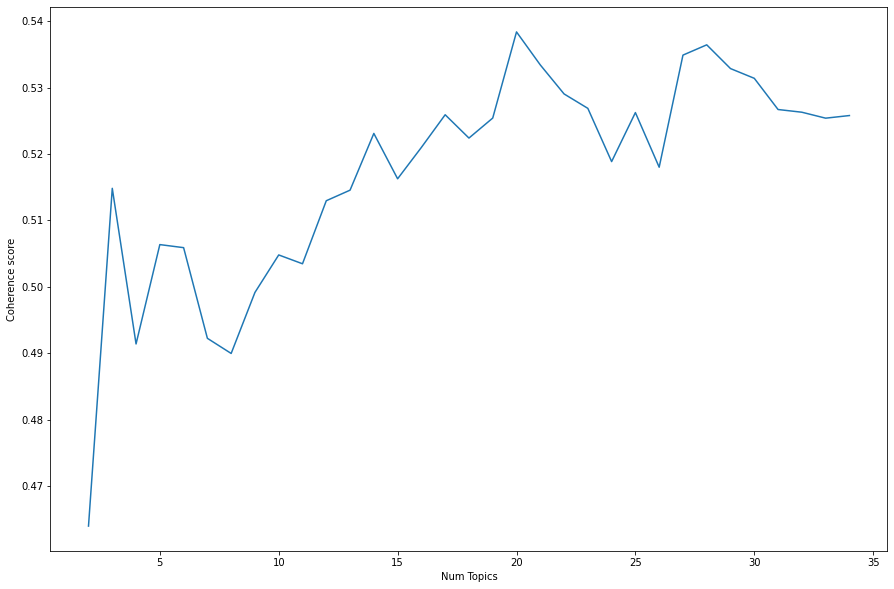

In [38]:
# Show graph
x = range(start, limit, step)
plt.figure(figsize=(15, 10))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
plt.show()

In [39]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6))

Num Topics = 2  has Coherence Value of 0.463948
Num Topics = 3  has Coherence Value of 0.514838
Num Topics = 4  has Coherence Value of 0.49139
Num Topics = 5  has Coherence Value of 0.506359
Num Topics = 6  has Coherence Value of 0.505898
Num Topics = 7  has Coherence Value of 0.492239
Num Topics = 8  has Coherence Value of 0.489959
Num Topics = 9  has Coherence Value of 0.499153
Num Topics = 10  has Coherence Value of 0.5048
Num Topics = 11  has Coherence Value of 0.503471
Num Topics = 12  has Coherence Value of 0.512968
Num Topics = 13  has Coherence Value of 0.514562
Num Topics = 14  has Coherence Value of 0.523108
Num Topics = 15  has Coherence Value of 0.516275
Num Topics = 16  has Coherence Value of 0.521003
Num Topics = 17  has Coherence Value of 0.525922
Num Topics = 18  has Coherence Value of 0.52241
Num Topics = 19  has Coherence Value of 0.525424
Num Topics = 20  has Coherence Value of 0.538404
Num Topics = 21  has Coherence Value of 0.533431
Num Topics = 22  has Coherence V

In [43]:
# Select the model and print the topics
index, value = max(enumerate(coherence_values), key=operator.itemgetter(1))
index = 10
optimal_model = model_list[index]
model_topics = optimal_model.show_topics(num_topics=1000, formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.021*"brahmana" + 0.016*"man" + 0.014*"sacrifice" + 0.013*"gift" + '
  '0.013*"food" + 0.012*"person" + 0.011*"merit" + 0.011*"give" + '
  '0.010*"brahmanas" + 0.009*"perform"'),
 (1,
  '0.019*"hath" + 0.016*"word" + 0.012*"ye" + 0.011*"grief" + 0.009*"-PRON-" + '
  '0.008*"heart" + 0.008*"lady" + 0.008*"time" + 0.008*"address" + '
  '0.008*"behold"'),
 (2,
  '0.182*"thou" + 0.088*"thee" + 0.086*"thy" + 0.052*"art" + 0.022*"hast" + '
  '0.015*"word" + 0.009*"address" + 0.008*"thine" + 0.008*"thyself" + '
  '0.007*"dost"'),
 (3,
  '0.046*"son" + 0.015*"great" + 0.014*"rishi" + 0.012*"brahmana" + '
  '0.011*"bear" + 0.011*"father" + 0.009*"wife" + 0.008*"ascetic" + '
  '0.008*"hear" + 0.008*"child"'),
 (4,
  '0.026*"man" + 0.018*"act" + 0.015*"person" + 0.014*"good" + 0.010*"virtue" '
  '+ 0.008*"wealth" + 0.008*"world" + 0.008*"life" + 0.007*"foe" + '
  '0.007*"duty"'),
 (5,
  '0.029*"god" + 0.019*"great" + 0.016*"lord" + 0.012*"call" + '
  '0.010*"foremost" + 0.010*"celestial"

In [44]:
optimal_model.show_topic(0,10)

[('brahmana', 0.020917959055500968),
 ('man', 0.0160658029356051),
 ('sacrifice', 0.014120888582744963),
 ('gift', 0.012763500440644658),
 ('food', 0.01260142424457298),
 ('person', 0.01168974564166979),
 ('merit', 0.01074767775200316),
 ('give', 0.010565342031422523),
 ('brahmanas', 0.009724571764300692),
 ('perform', 0.008681206252089263)]

In [45]:
for topic in sorted(optimal_model.show_topics(num_topics=1000, num_words=10, formatted=False), key=lambda x: x[0]):
    print('Topic {}: {}'.format(topic[0], [item[0] for item in topic[1]]))

Topic 0: ['brahmana', 'man', 'sacrifice', 'gift', 'food', 'person', 'merit', 'give', 'brahmanas', 'perform']
Topic 1: ['hath', 'word', 'ye', 'grief', '-PRON-', 'heart', 'lady', 'time', 'address', 'behold']
Topic 2: ['thou', 'thee', 'thy', 'art', 'hast', 'word', 'address', 'thine', 'thyself', 'dost']
Topic 3: ['son', 'great', 'rishi', 'brahmana', 'bear', 'father', 'wife', 'ascetic', 'hear', 'child']
Topic 4: ['man', 'act', 'person', 'good', 'virtue', 'wealth', 'world', 'life', 'foe', 'duty']
Topic 5: ['god', 'great', 'lord', 'call', 'foremost', 'celestial', 'indra', 'energy', 'universe', 'world']
Topic 6: ['tree', 'mountain', 'beautiful', 'body', 'head', 'begin', 'forest', 'sun', 'adorn', 'elephant']
Topic 7: ['king', 'yudhishthira', 'bharata', 'monarch', 'great', 'man', 'earth', 'foremost', 'kingdom', 'make']
Topic 8: ['soul', 'mind', 'knowledge', 'body', 'creature', 'act', 'sense', 'form', 'object', 'attain']
Topic 9: ['car', 'son', 'battle', 'warrior', 'arrow', 'great', 'king', 'dron

In [46]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,10.0,0.2693,"son, battle, arjuna, krishna, bhishma, duryodh...",1Om! Having bowed down unto Narayana and Nara...
1,1,10.0,0.3519,"son, battle, arjuna, krishna, bhishma, duryodh...","2Vaishampayana said, ""After the ladies had be..."
2,2,9.0,0.5449,"car, son, battle, warrior, arrow, great, king,...","3""Sanjaya said, 'Hear, O king, with attention..."
3,3,9.0,0.2324,"car, son, battle, warrior, arrow, great, king,...","4""Sanjaya said, 'Beholding the fallen boxes o..."
4,4,10.0,0.2499,"son, battle, arjuna, krishna, bhishma, duryodh...","5""Sanjaya said, 'Thus addressed by the celebr..."
...,...,...,...,...,...
2104,2104,3.0,0.2035,"son, great, rishi, brahmana, bear, father, wif...","XXXV""Vaisampayana said, 'King Dhritarashtra h..."
2105,2105,1.0,0.1851,"hath, word, ye, grief, -PRON-, heart, lady, ti...","XXXVI""Janamejaya said, 'Having seen his sons ..."
2106,2106,7.0,0.2262,"king, yudhishthira, bharata, monarch, great, m...","XXXVII(Naradagamana Parva)""Vaisampayana said,..."
2107,2107,1.0,0.2647,"hath, word, ye, grief, -PRON-, heart, lady, ti...","XXXVIII""Yudhishthira said, 'When such a fate ..."


In [47]:
df_dominant_topic[df_dominant_topic['Dominant_Topic'].isin([0, 1])]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
40,40,0.0,0.1821,"brahmana, man, sacrifice, gift, food, person, ...","41Vaishampayana said, ""The delighter of the Y..."
64,64,1.0,0.1793,"hath, word, ye, grief, -PRON-, heart, lady, ti...","65""Sanjaya said, 'Having heard of Duryodhana'..."
68,68,1.0,0.2988,"hath, word, ye, grief, -PRON-, heart, lady, ti...","4Vaishampayana said, ""Hearing this intelligen..."
108,108,0.0,0.3218,"brahmana, man, sacrifice, gift, food, person, ...","44""'Shalya said, ""These, O Karna, are ravings..."
109,109,0.0,0.1741,"brahmana, man, sacrifice, gift, food, person, ...","45""'Karna continued, ""Thou shouldst know all ..."
166,166,1.0,0.2641,"hath, word, ye, grief, -PRON-, heart, lady, ti...","III(Paushya Parva)Sauti said, ""Janamejaya, th..."
208,208,1.0,0.2682,"hath, word, ye, grief, -PRON-, heart, lady, ti...","XLV(Astika Parva continued)""Meanwhile the gre..."
255,255,0.0,0.1634,"brahmana, man, sacrifice, gift, food, person, ...","XCII(Sambhava Parva continued)""Ashtaka asked,..."
282,282,1.0,0.1909,"hath, word, ye, grief, -PRON-, heart, lady, ti...","CXIX(Sambhava Parva continued)""Vaisampayana s..."
284,284,1.0,0.2197,"hath, word, ye, grief, -PRON-, heart, lady, ti...","CXXI(Sambhava Parva continued)""Vaisampayana s..."


In [48]:
df_dominant_topic.to_csv('dominant_topic.csv')

In [49]:
[text.split() for text in df_dominant_topic['Keywords'].tolist()]

[['son,',
  'battle,',
  'arjuna,',
  'krishna,',
  'bhishma,',
  'duryodhana,',
  'slain,',
  'pandu,',
  'hero,',
  'foe'],
 ['son,',
  'battle,',
  'arjuna,',
  'krishna,',
  'bhishma,',
  'duryodhana,',
  'slain,',
  'pandu,',
  'hero,',
  'foe'],
 ['car,',
  'son,',
  'battle,',
  'warrior,',
  'arrow,',
  'great,',
  'king,',
  'drona,',
  'pierce,',
  'steed'],
 ['car,',
  'son,',
  'battle,',
  'warrior,',
  'arrow,',
  'great,',
  'king,',
  'drona,',
  'pierce,',
  'steed'],
 ['son,',
  'battle,',
  'arjuna,',
  'krishna,',
  'bhishma,',
  'duryodhana,',
  'slain,',
  'pandu,',
  'hero,',
  'foe'],
 ['car,',
  'son,',
  'battle,',
  'warrior,',
  'arrow,',
  'great,',
  'king,',
  'drona,',
  'pierce,',
  'steed'],
 ['car,',
  'son,',
  'battle,',
  'warrior,',
  'arrow,',
  'great,',
  'king,',
  'drona,',
  'pierce,',
  'steed'],
 ['car,',
  'son,',
  'battle,',
  'warrior,',
  'arrow,',
  'great,',
  'king,',
  'drona,',
  'pierce,',
  'steed'],
 ['car,',
  'son,',
  'batt

In [50]:
for idx, row in df_dominant_topic.iterrows():
    print('{}. Dominant keywords: {}'.format(row['Document_No'], row['Keywords'].split(', ')[:5]))

0. Dominant keywords: ['son', 'battle', 'arjuna', 'krishna', 'bhishma']
1. Dominant keywords: ['son', 'battle', 'arjuna', 'krishna', 'bhishma']
2. Dominant keywords: ['car', 'son', 'battle', 'warrior', 'arrow']
3. Dominant keywords: ['car', 'son', 'battle', 'warrior', 'arrow']
4. Dominant keywords: ['son', 'battle', 'arjuna', 'krishna', 'bhishma']
5. Dominant keywords: ['car', 'son', 'battle', 'warrior', 'arrow']
6. Dominant keywords: ['car', 'son', 'battle', 'warrior', 'arrow']
7. Dominant keywords: ['car', 'son', 'battle', 'warrior', 'arrow']
8. Dominant keywords: ['car', 'son', 'battle', 'warrior', 'arrow']
9. Dominant keywords: ['car', 'son', 'battle', 'warrior', 'arrow']
10. Dominant keywords: ['car', 'son', 'battle', 'warrior', 'arrow']
11. Dominant keywords: ['car', 'son', 'battle', 'warrior', 'arrow']
12. Dominant keywords: ['car', 'son', 'battle', 'warrior', 'arrow']
13. Dominant keywords: ['car', 'son', 'battle', 'warrior', 'arrow']
14. Dominant keywords: ['car', 'son', 'batt

599. Dominant keywords: ['car', 'son', 'battle', 'warrior', 'arrow']
600. Dominant keywords: ['car', 'son', 'battle', 'warrior', 'arrow']
601. Dominant keywords: ['car', 'son', 'battle', 'warrior', 'arrow']
602. Dominant keywords: ['car', 'son', 'battle', 'warrior', 'arrow']
603. Dominant keywords: ['car', 'son', 'battle', 'warrior', 'arrow']
604. Dominant keywords: ['car', 'son', 'battle', 'warrior', 'arrow']
605. Dominant keywords: ['car', 'son', 'battle', 'warrior', 'arrow']
606. Dominant keywords: ['car', 'son', 'battle', 'warrior', 'arrow']
607. Dominant keywords: ['car', 'son', 'battle', 'warrior', 'arrow']
608. Dominant keywords: ['car', 'son', 'battle', 'warrior', 'arrow']
609. Dominant keywords: ['car', 'son', 'battle', 'warrior', 'arrow']
610. Dominant keywords: ['car', 'son', 'battle', 'warrior', 'arrow']
611. Dominant keywords: ['son', 'battle', 'arjuna', 'krishna', 'bhishma']
612. Dominant keywords: ['son', 'battle', 'arjuna', 'krishna', 'bhishma']
613. Dominant keywords: 

974. Dominant keywords: ['man', 'act', 'person', 'good', 'virtue']
975. Dominant keywords: ['brahmana', 'man', 'sacrifice', 'gift', 'food']
976. Dominant keywords: ['brahmana', 'man', 'sacrifice', 'gift', 'food']
977. Dominant keywords: ['brahmana', 'man', 'sacrifice', 'gift', 'food']
978. Dominant keywords: ['brahmana', 'man', 'sacrifice', 'gift', 'food']
979. Dominant keywords: ['brahmana', 'man', 'sacrifice', 'gift', 'food']
980. Dominant keywords: ['hath', 'word', 'ye', 'grief', '-PRON-']
981. Dominant keywords: ['man', 'act', 'person', 'good', 'virtue']
982. Dominant keywords: ['god', 'great', 'lord', 'call', 'foremost']
983. Dominant keywords: ['god', 'great', 'lord', 'call', 'foremost']
984. Dominant keywords: ['thou', 'thee', 'thy', 'art', 'hast']
985. Dominant keywords: ['thou', 'thee', 'thy', 'art', 'hast']
986. Dominant keywords: ['god', 'great', 'lord', 'call', 'foremost']
987. Dominant keywords: ['god', 'great', 'lord', 'call', 'foremost']
988. Dominant keywords: ['hath', 

1537. Dominant keywords: ['man', 'act', 'person', 'good', 'virtue']
1538. Dominant keywords: ['man', 'act', 'person', 'good', 'virtue']
1539. Dominant keywords: ['brahmana', 'man', 'sacrifice', 'gift', 'food']
1540. Dominant keywords: ['soul', 'mind', 'knowledge', 'body', 'creature']
1541. Dominant keywords: ['soul', 'mind', 'knowledge', 'body', 'creature']
1542. Dominant keywords: ['man', 'act', 'person', 'good', 'virtue']
1543. Dominant keywords: ['soul', 'mind', 'knowledge', 'body', 'creature']
1544. Dominant keywords: ['soul', 'mind', 'knowledge', 'body', 'creature']
1545. Dominant keywords: ['soul', 'mind', 'knowledge', 'body', 'creature']
1546. Dominant keywords: ['soul', 'mind', 'knowledge', 'body', 'creature']
1547. Dominant keywords: ['soul', 'mind', 'knowledge', 'body', 'creature']
1548. Dominant keywords: ['soul', 'mind', 'knowledge', 'body', 'creature']
1549. Dominant keywords: ['soul', 'mind', 'knowledge', 'body', 'creature']
1550. Dominant keywords: ['soul', 'mind', 'know

1888. Dominant keywords: ['tree', 'mountain', 'beautiful', 'body', 'head']
1889. Dominant keywords: ['car', 'son', 'battle', 'warrior', 'arrow']
1890. Dominant keywords: ['tree', 'mountain', 'beautiful', 'body', 'head']
1891. Dominant keywords: ['tree', 'mountain', 'beautiful', 'body', 'head']
1892. Dominant keywords: ['tree', 'mountain', 'beautiful', 'body', 'head']
1893. Dominant keywords: ['tree', 'mountain', 'beautiful', 'body', 'head']
1894. Dominant keywords: ['tree', 'mountain', 'beautiful', 'body', 'head']
1895. Dominant keywords: ['tree', 'mountain', 'beautiful', 'body', 'head']
1896. Dominant keywords: ['son', 'battle', 'arjuna', 'krishna', 'bhishma']
1897. Dominant keywords: ['son', 'great', 'rishi', 'brahmana', 'bear']
1898. Dominant keywords: ['son', 'great', 'rishi', 'brahmana', 'bear']
1899. Dominant keywords: ['son', 'great', 'rishi', 'brahmana', 'bear']
1900. Dominant keywords: ['hath', 'word', 'ye', 'grief', '-PRON-']
1901. Dominant keywords: ['hath', 'word', 'ye', 'g

In [51]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.6500,"brahmana, man, sacrifice, gift, food, person, ...","LXVI""Yudhishthira said, 'I desire to hear, O ..."
1,1.0,0.5554,"hath, word, ye, grief, -PRON-, heart, lady, ti...","LXII""Nala said, 'Surely, thy father's kingdom..."
2,2.0,0.4904,"thou, thee, thy, art, hast, word, address, thi...","CCLXXXV""Yudhishthira said, 'It behoveth thee,..."
3,3.0,0.5558,"son, great, rishi, brahmana, bear, father, wif...","XCV(Sambhava Parva continued)""Janamejaya said..."
4,4.0,0.6161,"man, act, person, good, virtue, wealth, world,...","XCIII""Vamadeva continued, 'When the king, who..."
5,5.0,0.6145,"god, great, lord, call, foremost, celestial, i...","LXXXIII""Pulastya said, 'One should next proce..."
6,6.0,0.6143,"tree, mountain, beautiful, body, head, begin, ...","CLVIIVaisampayana continued, ""On that Rakshas..."
7,7.0,0.4813,"king, yudhishthira, bharata, monarch, great, m...","XXIXVaisampayana said,--that chastiser of all..."
8,8.0,0.7640,"soul, mind, knowledge, body, creature, act, se...","CCCVII'""Janaka said, Thou hast, O foremost of..."
9,9.0,0.8199,"car, son, battle, warrior, arrow, great, king,...","CXIVSanjaya said, ""Hearing these words of the..."


In [52]:
for idx, row in sent_topics_sorteddf_mallet.iterrows():
    print('Topic number {}'.format(int(row['Topic_Num'])))
    print('Keywords: {}'.format(row['Keywords']))
    print()
    print(row['Text'])
    print()

Topic number 0
Keywords: brahmana, man, sacrifice, gift, food, person, merit, give, brahmanas, perform

 LXVI"Yudhishthira said, 'I desire to hear, O grandsire, what the merits areof that person who makes the gift of a pair of sandals unto a Brahmanawhose feet are burning or being scorched by hot sand, while he iswalking.'"Bhishma said, 'The man, that gives unto the Brahmanas sandals for theprotection of their feet, succeeds in crushing all thorns and gets overevery kind of difficulty. Such a man, O Yudhishthira, stays over theheads of all his foes. Vehicles of pure splendour, with mules harnessedthereto, and made of gold and silver, O monarch, approach him. He whomakes a gift of sandals is said to earn the merit of making the gift of avehicle with well-broken steeds yoked thereto.'"Yudhishthira said, 'Do thou tell me in detail once more, O grandsire, ofthe merits that attach to gifts of sesame and land and kine and food.'"Bhishma said, 'Do thou hear, O son of Kunti, what the merits ar

In [53]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Percent_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0.0,0.0,"brahmana, man, sacrifice, gift, food, person, ...",176,0.0835
1.0,1.0,"hath, word, ye, grief, -PRON-, heart, lady, ti...",162,0.0768
2.0,2.0,"thou, thee, thy, art, hast, word, address, thi...",77,0.0365
3.0,3.0,"son, great, rishi, brahmana, bear, father, wif...",213,0.1010
4.0,4.0,"man, act, person, good, virtue, wealth, world,...",211,0.1000
5.0,5.0,"god, great, lord, call, foremost, celestial, i...",173,0.0820
6.0,6.0,"tree, mountain, beautiful, body, head, begin, ...",124,0.0588
7.0,7.0,"king, yudhishthira, bharata, monarch, great, m...",146,0.0692
8.0,8.0,"soul, mind, knowledge, body, creature, act, se...",178,0.0844
9.0,9.0,"car, son, battle, warrior, arrow, great, king,...",359,0.1702


In [54]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    pd.set_option('display.max_colwidth', -1)
    display(df_dominant_topics)

<ipython-input-54-ac90e0fd5d9d>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0.0,0.0,"brahmana, man, sacrifice, gift, food, person, merit, give, brahmanas, perform",176,0.0835
1.0,1.0,"hath, word, ye, grief, -PRON-, heart, lady, time, address, behold",162,0.0768
2.0,2.0,"thou, thee, thy, art, hast, word, address, thine, thyself, dost",77,0.0365
3.0,3.0,"son, great, rishi, brahmana, bear, father, wife, ascetic, hear, child",213,0.1010
4.0,4.0,"man, act, person, good, virtue, wealth, world, life, foe, duty",211,0.1000
5.0,5.0,"god, great, lord, call, foremost, celestial, indra, energy, universe, world",173,0.0820
6.0,6.0,"tree, mountain, beautiful, body, head, begin, forest, sun, adorn, elephant",124,0.0588
7.0,7.0,"king, yudhishthira, bharata, monarch, great, man, earth, foremost, kingdom, make",146,0.0692
8.0,8.0,"soul, mind, knowledge, body, creature, act, sense, form, object, attain",178,0.0844
9.0,9.0,"car, son, battle, warrior, arrow, great, king, drona, pierce, steed",359,0.1702


In [55]:
df_dominant_topics.to_csv('df_dominant_topics2.csv', index=False)